In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))
library(parallel)
library(data.table)
library(cowplot)
library(ggsci)
library(aplot)

options(warn=-1)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [2]:
file_list<-list.files(path = paste0("01C_DESeq2_D0_VS_D7_L3/"), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

## file_list

In [3]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [4]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [5]:
DEG<-DEG %>% filter(Year=='Y1')

In [6]:
freq <- DEG %>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-D0",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-D0",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  group_by(celltype, Expression) %>%
  summarise(count = n())
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-D0"~-count,TRUE~count))

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


In [7]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

In [8]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

In [9]:
total_gene <- DEG  %>%
  group_by(celltype) %>%
  summarise(count = n())
total_gene$celltype<-factor(total_gene$celltype,levels=orders)

In [10]:
p2<-ggplot(total_gene, aes(x = celltype, y = count)) +
  geom_bar(stat = "identity", position = "identity") +
  labs(x = "celltype", y = "Total_Genes_Expressed")+theme_bw(base_size=12)+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ylab('N_Genes')

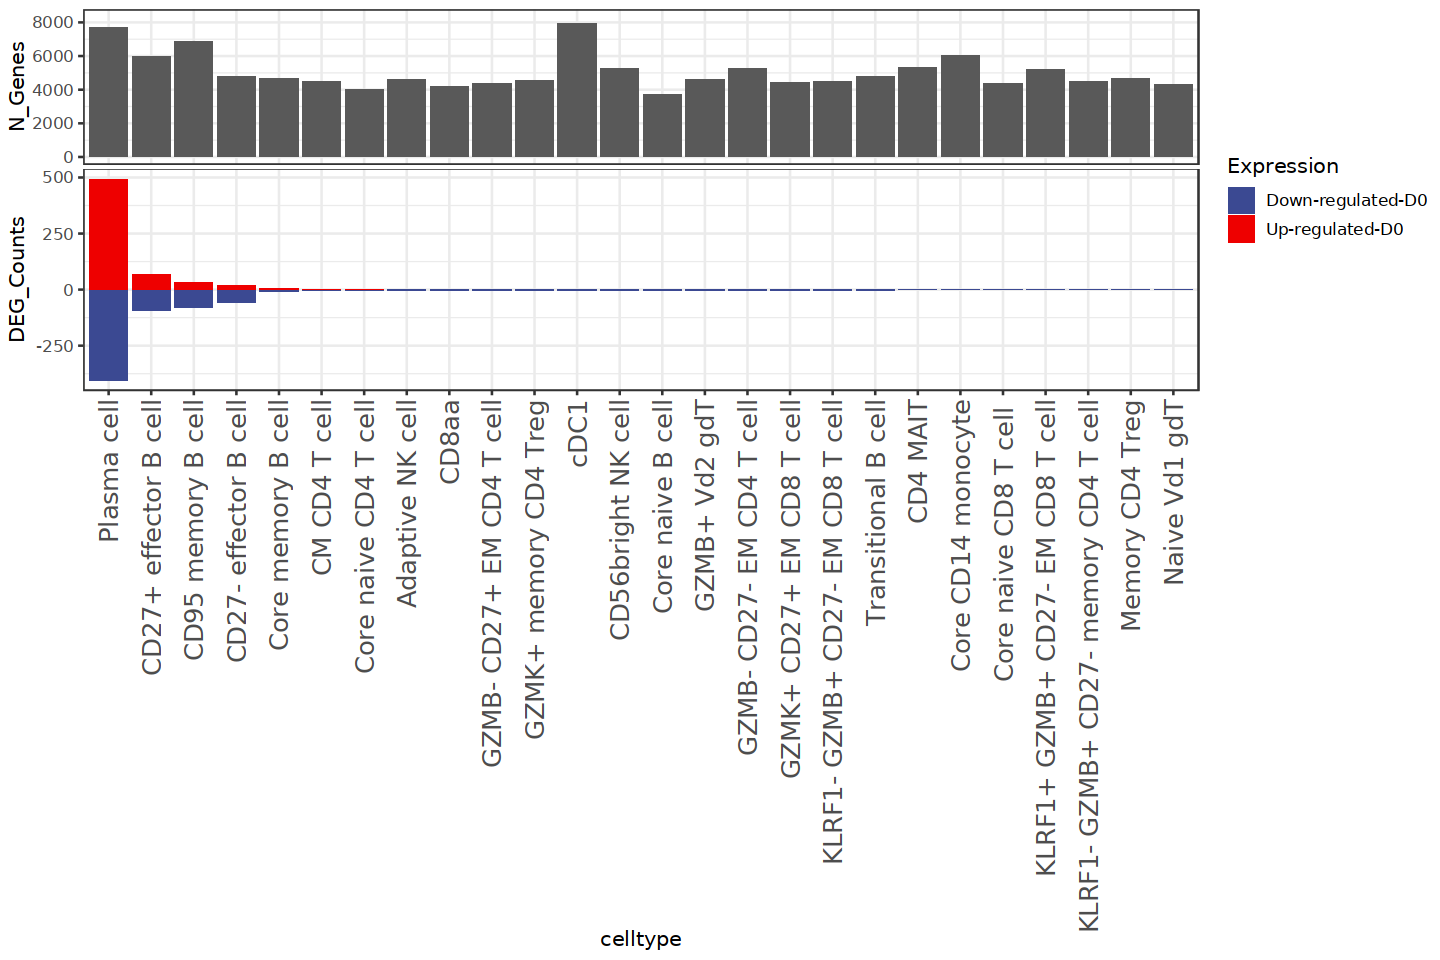

In [11]:
options(repr.plot.width = 12, repr.plot.height = 8)

p3<-p1 %>% insert_top(p2,height=0.7)

p3

